In [21]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn import linear_model
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error


In [42]:
df = pd.read_csv("data-p2/all_interactions_mimic3d.csv")

In [44]:
# x1 = df["NumTransfers admit_type_EMERGENCY"]
# x2 = df["NumCallouts"]
# x3 = df["NumCallouts NumProcs"]
# x4 = df["NumTransfers insurance_Medicare"]
# x5 = df["NumTransfers insurance_Private"]
y = df["LOSdays"]

x1 = df['NumCallouts']
x2 = df['NumCallouts NumTransfers']
x3 = df['NumRx AdmitProcedure_4']
x4 = df['NumTransfers insurance_Private']
x5 = df['NumChartEvents admit_type_NEWBORN']

In [47]:
with pm.Model() as model:
    intercept = pm.Normal('intercept', mu=9.487181, sigma=1000)
    slope_1 = pm.Normal('NumCallouts', mu=-21.558029, sigma=1000)
    slope_2 = pm.Normal('NumCallouts NumTransfers', mu=6.778423, sigma=1000)
    slope_3 = pm.Normal('NumRx AdmitProcedure_4', mu=-0.272798, sigma=1000)
    slope_4 = pm.Normal('NumTransfers insurance_Private', mu=-0.966814, sigma=1000)
    slope_5 = pm.Normal('NumChartEvents admit_type_NEWBORN', mu=0.018115, sigma=1000)
    
    sigma = pm.Exponential('sigma', lam=0.0001)
    
    mu = (intercept
          + slope_1 * x1 
          + slope_2 * x2
          + slope_3 * x3
          + slope_4 * x4
          + slope_5 * x5
    )
    
    likelihood = pm.Normal('y', mu=mu, sigma=sigma, observed=y)
    
    trace = pm.sample(2000, return_inferencedata=True, progressbar=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, NumCallouts, NumCallouts NumTransfers, NumRx AdmitProcedure_4, NumTransfers insurance_Private, NumChartEvents admit_type_NEWBORN, sigma]


c:\Users\mairi\code\MAT-4376E-F24\.conda\Lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 48 seconds.


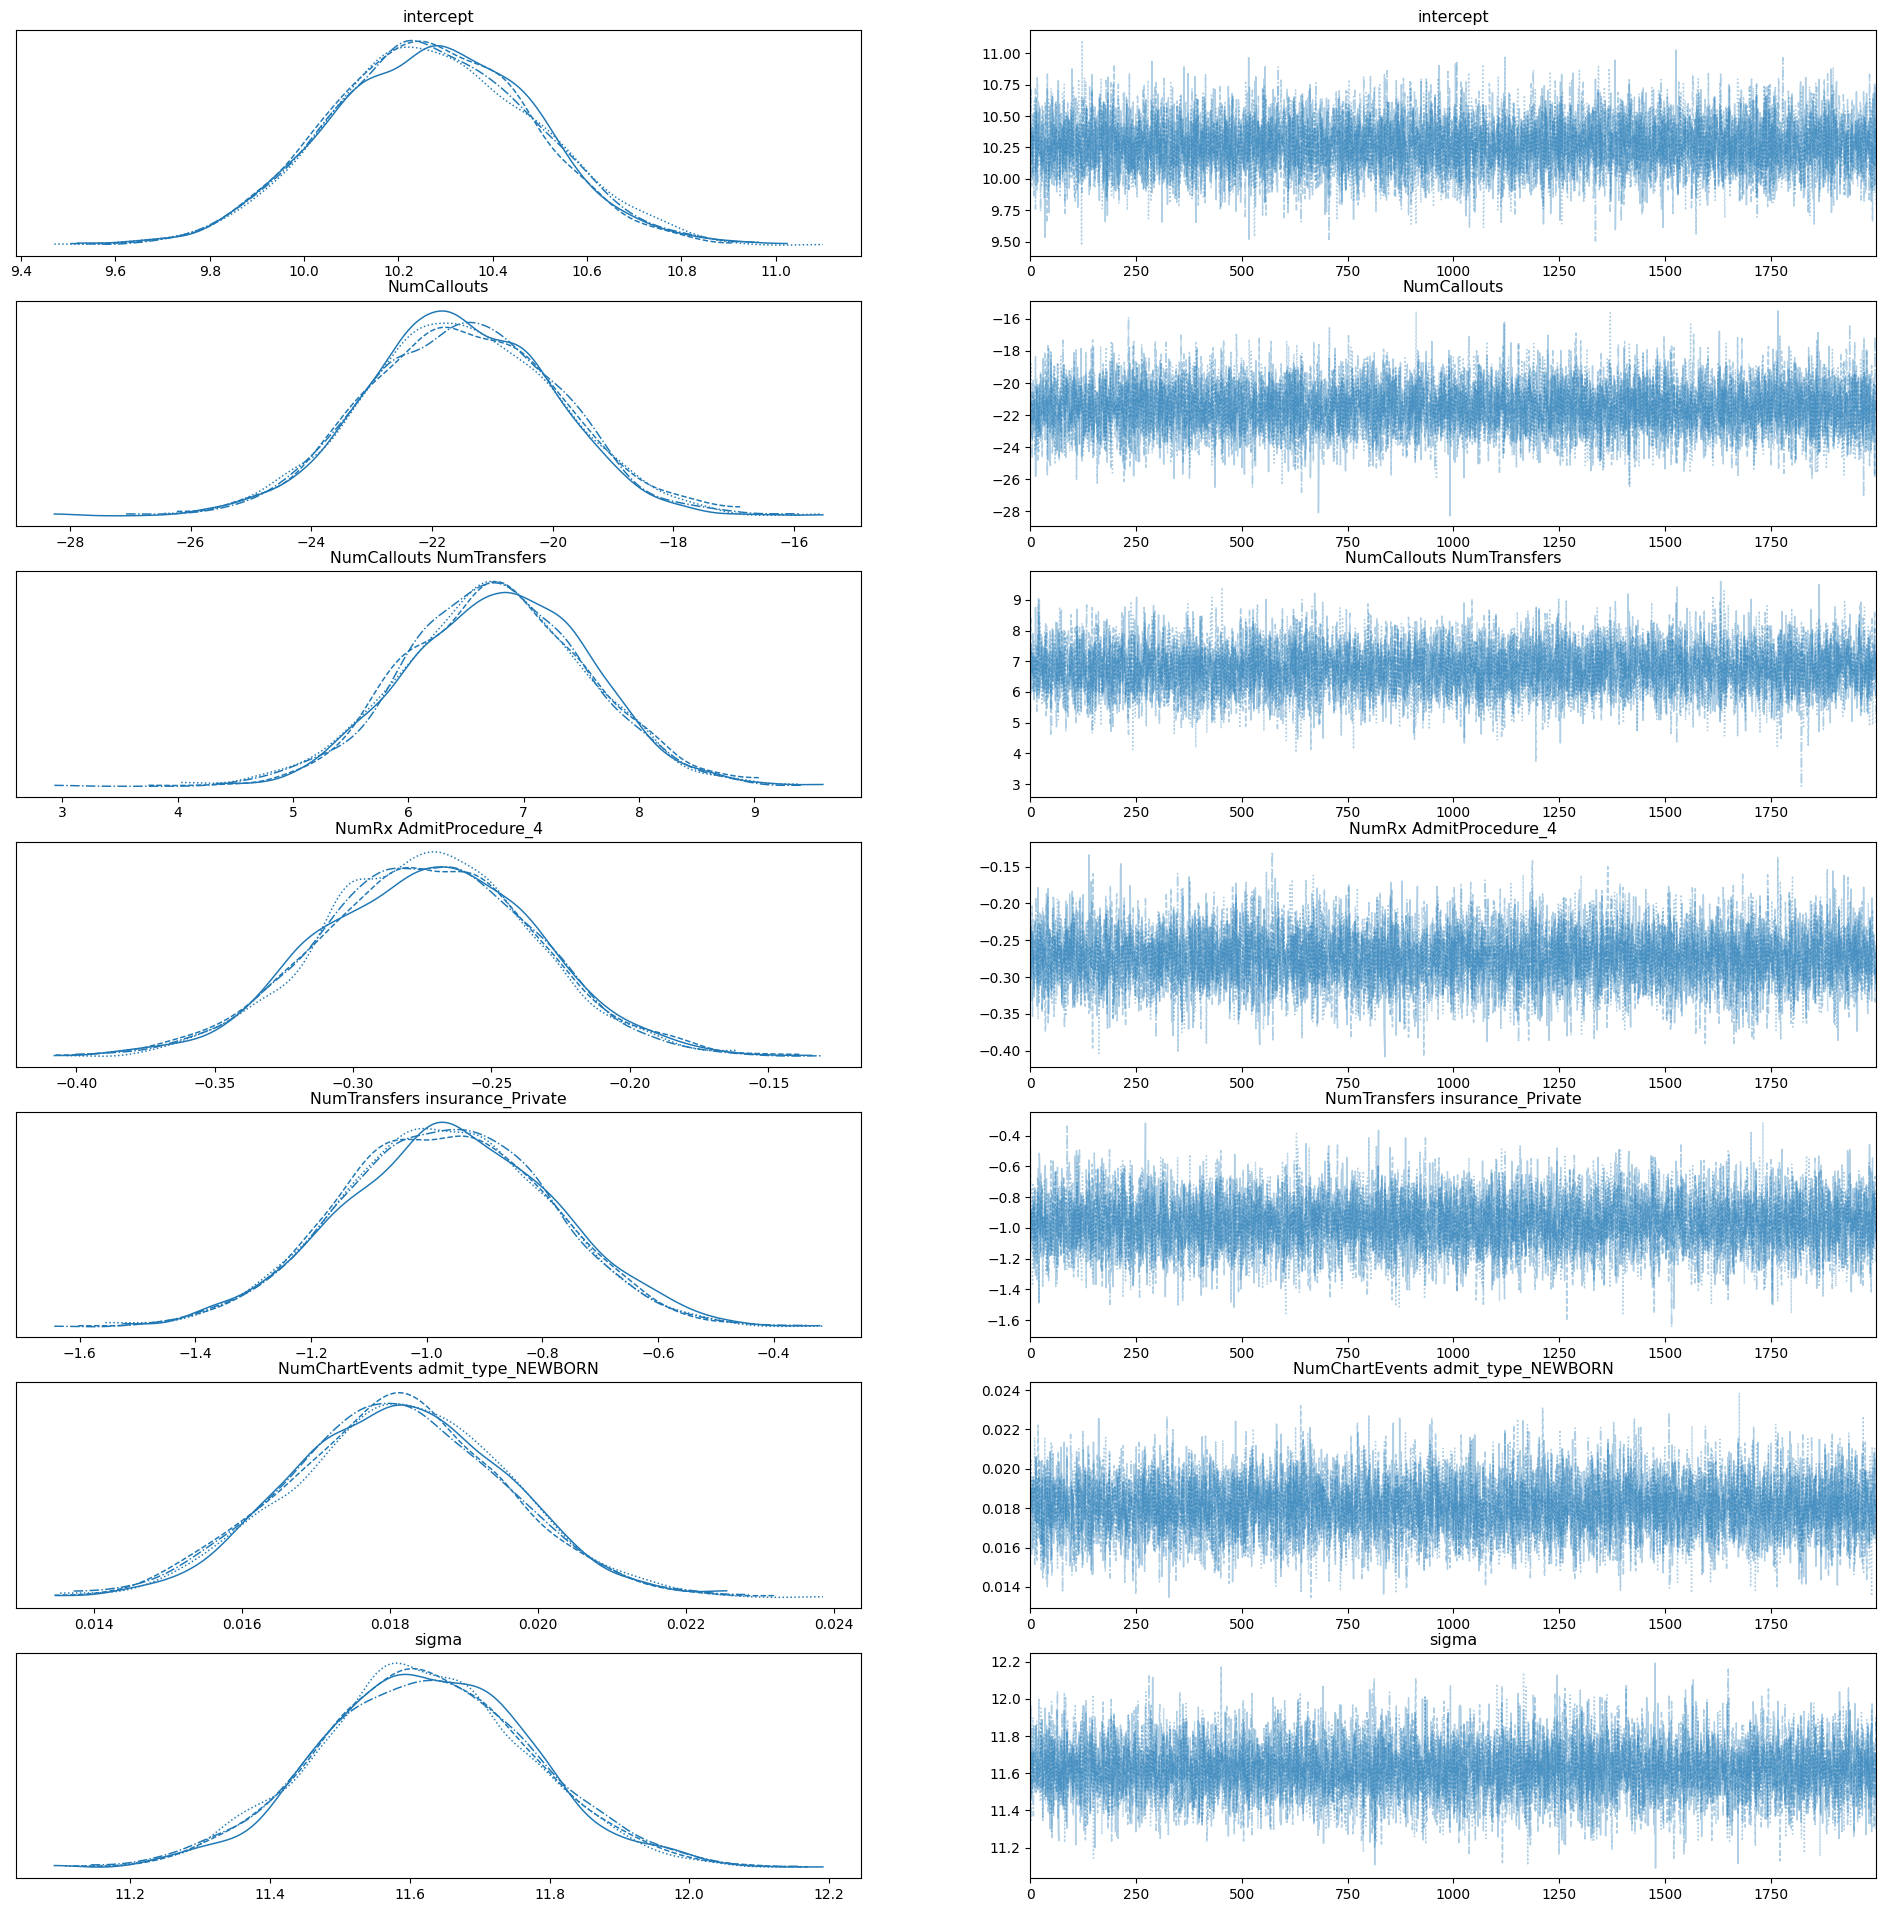

In [48]:
az.plot_trace(trace, figsize=(24, 24))

# Show the plot
plt.show()